# MolProp-модель

В данном блокноте производится оценка модели на основе предсказаний HERG-активности в MolProp.
А именно:
1. На вход MolProp поступили данные из ChEMBL (29v) после процедуры data preparation
2. Результаты после работы MolProp были сохранены в файл qikprop_8k.csv
3. Результаты работы MolProp по оценке herg-активности (QPlogHERG) были сопоставлены с реальными значениями IC50 из ChEMBL по классу, которые был определен в data preparation (более 10 мкм - неактивные, менее 10 мкм - блокаторы).
4. Были посчитаны все метрики: ~roc_auc, accuracy, precision, recall, f1-score

In [1]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
#import mols2grid
# mols2grid.useSVG=True
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from pandas import DataFrame
import pandas as pd
from rdkit.Chem import AllChem, Draw
import numpy as np
from csv import reader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
def read_sdf(file):
    data_name = file
    data = [] # container for molecules
    for mol in Chem.SDMolSupplier(data_name):
        if mol is not None:
            data.append(mol)
    return data

In [3]:
data = read_sdf("herg_smaller_right.sdf")

In [5]:
df = pd.read_table('herg_out_smaller_right.csv', sep = ",", engine='python')
df

,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.950,14.0,1,7.853872
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144
2,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.380,5950.0,1,5.225483
3,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1,6.844664
4,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1,6.707744
...,...,...,...,...,...,...,...,...,...,...,...
7874,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798
7875,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453
7876,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984
7877,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696


# Прочитаем результаты полученного файла из MolProp

In [6]:
def read_csv_with_nan(csv_file):
    # open file in read mode
    with open(csv_file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        a = []
        for row in csv_reader:
            a.append(row)
            # row variable is a list that represents a row in csv
            # print(row)
    d_schroedinger = pd.DataFrame(a)
    d_schroedinger.columns = d_schroedinger.iloc[0]
    d_schroedinger = d_schroedinger[1:]
    d_schroedinger.reset_index(drop=True, inplace=True)
    d_schroedinger = d_schroedinger.loc[:, d_schroedinger.columns.notnull()]
    return d_schroedinger

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
molprop = read_csv_with_nan("qikprop_7k.csv")
molprop

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPlogHERG,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,CHEMBL12713,1,1,0,0,0,3,0,1,440.947,7.294,761.664,293.212,83.169,266.744,118.538,1357.996,1.000,4.000,0.0391812,0.0052517,0.7786351,48.814,13.861,20.711,8.717,5.802,-7.488,-6.655,-7.112,401.892,0.158,911.323,-3.887,8.287,0.737,2,1.406,1,94.566,47.013,0.000,53.329,5,1,26,0,26,7,31,1,0.000
1,CHEMBL1108,0,1,0,0,0,5,0,1,379.433,5.335,688.755,177.594,125.727,338.396,47.039,1213.372,1.000,6.000,0.0234580,0.0087114,0.7987846,42.426,12.714,19.294,10.822,3.501,-4.768,-4.546,-7.128,158.684,-0.538,135.450,-4.227,8.729,0.849,4,0.516,3,86.833,47.039,0.000,77.075,5,0,21,0,21,3,28,0,0.000
2,CHEMBL2368925,0,1,0,0,0,2,1,1,324.379,4.883,586.577,257.421,112.191,216.965,0.000,1029.591,0.000,5.000,0.0231582,0.0000000,0.8406521,35.838,10.085,14.703,7.854,2.528,-3.170,-3.210,-5.871,213.250,-0.217,103.000,-4.693,8.605,0.334,2,0.184,3,83.429,0.000,0.000,75.722,5,0,20,0,20,9,24,0,0.004
3,CHEMBL6966,0,1,0,0,0,14,0,1,454.608,6.826,678.150,557.072,36.750,84.328,0.000,1416.270,0.000,6.500,0.0328995,0.0000000,0.8993662,42.341,12.123,17.312,5.489,4.027,-4.280,-6.384,-4.289,1107.391,-0.185,611.102,-2.618,8.388,-0.121,6,0.396,3,100.000,0.000,0.000,51.629,6,0,12,0,12,0,33,0,0.747
4,CHEMBL1107,3,1,0,0,0,11,0,2,500.430,1.992,801.252,373.323,13.430,164.009,250.490,1471.548,1.000,3.700,0.0026955,0.0046178,0.7808701,47.241,13.670,19.421,5.625,7.526,-7.605,-7.751,-6.586,1842.638,0.767,10000.000,-2.196,8.868,1.494,2,1.449,1,100.000,117.620,0.000,20.369,2,2,14,0,14,0,33,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,CHEMBL4635883,0,1,0,0,0,6,0,-1,397.522,5.262,704.539,470.667,152.295,81.577,0.000,1299.014,4.000,6.500,0.0213186,0.0184518,0.8172141,42.759,12.848,23.568,13.943,2.738,-4.207,-4.185,-5.605,88.836,-0.920,39.974,-5.525,8.579,0.541,5,0.457,3,77.852,0.000,0.000,114.703,8,0,18,0,18,5,29,0,0.000
7875,CHEMBL4643105,1,0,0,0,0,3,0,1,464.514,5.551,801.623,374.206,54.017,279.466,93.934,1443.612,0.000,5.450,0.0213431,0.0000000,0.7705993,52.362,13.563,20.778,8.656,6.371,-8.475,-7.704,-6.577,3045.511,0.007,5391.414,-1.243,8.959,1.083,5,1.224,1,100.000,93.934,0.000,46.398,6,1,27,0,27,5,34,1,0.000
7876,CHEMBL4634921,2,0,0,0,0,3,0,1,482.504,5.016,808.996,374.210,54.007,250.154,130.624,1458.107,0.000,5.450,0.0172566,0.0000000,0.7686795,52.662,13.267,20.956,8.487,6.571,-8.775,-8.086,-6.468,3046.129,0.094,8566.089,-1.346,8.990,1.135,4,1.266,1,100.000,130.624,0.000,46.395,6,1,27,0,27,5,35,1,0.000
7877,CHEMBL4634696,1,0,0,0,0,1,0,1,468.478,7.765,779.532,338.619,67.409,242.861,130.644,1402.407,0.000,5.450,0.0429939,0.0000000,0.7772849,51.648,12.734,21.102,8.899,6.107,-8.542,-7.549,-6.294,2273.341,0.080,6244.929,-1.810,9.032,1.180,4,1.189,1,100.000,130.644,0.000,49.142,6,1,28,0,23,5,34,1,0.000


In [9]:
def calculate_IC50(i):
    # рассчитывается из QPlogHERG (данная величина соответсвует log(IC50), где IC50 в моль/л), функция calculate_IC50 переводит данное значение в IC50 в нМ.
    p = (10**i)*1000000000
    return p 

In [10]:
molprop = molprop[["molecule","QPlogHERG"]]
molprop["QPlogHERG"] = pd.to_numeric(molprop["QPlogHERG"])
molprop["IC50_nM"] = molprop['QPlogHERG'].apply(calculate_IC50)
molprop

C:\Users\elly-\AppData\Local\Temp/ipykernel_8100/197140055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molprop["QPlogHERG"] = pd.to_numeric(molprop["QPlogHERG"])
C:\Users\elly-\AppData\Local\Temp/ipykernel_8100/197140055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molprop["IC50_nM"] = molprop['QPlogHERG'].apply(calculate_IC50)


,molecule,QPlogHERG,IC50_nM
0,CHEMBL12713,-7.112,77.268059
1,CHEMBL1108,-7.128,74.473197
2,CHEMBL2368925,-5.871,1345.860354
3,CHEMBL6966,-4.289,51404.365158
4,CHEMBL1107,-6.586,259.417936
...,...,...,...
7874,CHEMBL4635883,-5.605,2483.133105
7875,CHEMBL4643105,-6.577,264.850014
7876,CHEMBL4634921,-6.468,340.408190
7877,CHEMBL4634696,-6.294,508.159443


In [11]:
def activity_class(df):
    activity_class =[]
    for i in df["IC50_nM"]:
        if i >= 10000:           
            activity_class.append(0)
        else:
            activity_class.append(1)
    df['class_molprop'] = activity_class
    return df

In [12]:
molprop = activity_class(molprop)
molprop

C:\Users\elly-\AppData\Local\Temp/ipykernel_8100/1337807856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_molprop'] = activity_class


,molecule,QPlogHERG,IC50_nM,class_molprop
0,CHEMBL12713,-7.112,77.268059,1
1,CHEMBL1108,-7.128,74.473197,1
2,CHEMBL2368925,-5.871,1345.860354,1
3,CHEMBL6966,-4.289,51404.365158,0
4,CHEMBL1107,-6.586,259.417936,1
...,...,...,...,...
7874,CHEMBL4635883,-5.605,2483.133105,1
7875,CHEMBL4643105,-6.577,264.850014,1
7876,CHEMBL4634921,-6.468,340.408190,1
7877,CHEMBL4634696,-6.294,508.159443,1


In [13]:
molprop['QPlogHERG'].isna().sum()

36

36 молекул MolProp сичтать отказался

In [14]:
is_NaN = molprop.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = molprop[row_has_NaN]
index_nan = rows_with_NaN.index.values

In [15]:
molprop = pd.concat([molprop,df["class"]],axis=1)
molprop

,molecule,QPlogHERG,IC50_nM,class_molprop,class
0,CHEMBL12713,-7.112,77.268059,1,1
1,CHEMBL1108,-7.128,74.473197,1,1
2,CHEMBL2368925,-5.871,1345.860354,1,1
3,CHEMBL6966,-4.289,51404.365158,0,1
4,CHEMBL1107,-6.586,259.417936,1,1
...,...,...,...,...,...
7874,CHEMBL4635883,-5.605,2483.133105,1,1
7875,CHEMBL4643105,-6.577,264.850014,1,1
7876,CHEMBL4634921,-6.468,340.408190,1,1
7877,CHEMBL4634696,-6.294,508.159443,1,1


In [16]:
molprop.dropna()

,molecule,QPlogHERG,IC50_nM,class_molprop,class
0,CHEMBL12713,-7.112,77.268059,1,1
1,CHEMBL1108,-7.128,74.473197,1,1
2,CHEMBL2368925,-5.871,1345.860354,1,1
3,CHEMBL6966,-4.289,51404.365158,0,1
4,CHEMBL1107,-6.586,259.417936,1,1
...,...,...,...,...,...
7874,CHEMBL4635883,-5.605,2483.133105,1,1
7875,CHEMBL4643105,-6.577,264.850014,1,1
7876,CHEMBL4634921,-6.468,340.408190,1,1
7877,CHEMBL4634696,-6.294,508.159443,1,1


In [17]:
molprop = molprop.astype({"class_molprop": int, "class": int})

In [18]:
# Расчет TN, TP, FN, FP:
tn, fp, fn, tp = confusion_matrix(molprop["class"], molprop["class_molprop"]).ravel()
print(f'True negative: {tn}, False positive:  {fp}, False negative {fn}, True positive {tp}')

True negative: 947, False positive:  3180, False negative 334, True positive 3418


In [19]:
fpr = (fp / (fp + tn))
tpr = (tp / (tp + fn))
print(f'False positive rate : {fpr}, True positive rate:  {tpr}')

False positive rate : 0.7705354979403926, True positive rate:  0.9109808102345416


In [20]:
target_names = ["class nonblockers", "class blockers"]
print(classification_report(molprop["class"], molprop["class_molprop"], target_names=target_names))

                   precision    recall  f1-score   support

class nonblockers       0.74      0.23      0.35      4127
   class blockers       0.52      0.91      0.66      3752

         accuracy                           0.55      7879
        macro avg       0.63      0.57      0.51      7879
     weighted avg       0.63      0.55      0.50      7879



In [21]:
# probs = classif.predict_proba(X_test)
# preds = probs[:,1]]
y_test = molprop["class"]
prob = molprop["class_molprop"]
fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)

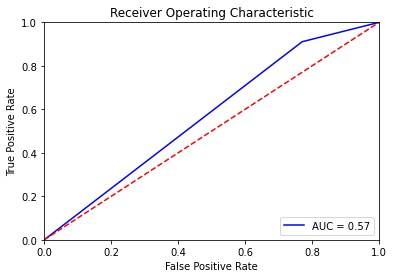

In [22]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
# 3537 молекул предсказались как активные и на самом деле были активными
molprop[(molprop["class_molprop"] == 1) & (molprop["class"] == 1)]

,molecule,QPlogHERG,IC50_nM,class_molprop,class
0,CHEMBL12713,-7.112,77.268059,1,1
1,CHEMBL1108,-7.128,74.473197,1,1
2,CHEMBL2368925,-5.871,1345.860354,1,1
4,CHEMBL1107,-6.586,259.417936,1,1
5,CHEMBL998,-5.654,2218.196420,1,1
...,...,...,...,...,...
7874,CHEMBL4635883,-5.605,2483.133105,1,1
7875,CHEMBL4643105,-6.577,264.850014,1,1
7876,CHEMBL4634921,-6.468,340.408190,1,1
7877,CHEMBL4634696,-6.294,508.159443,1,1


D:\Anaconda\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


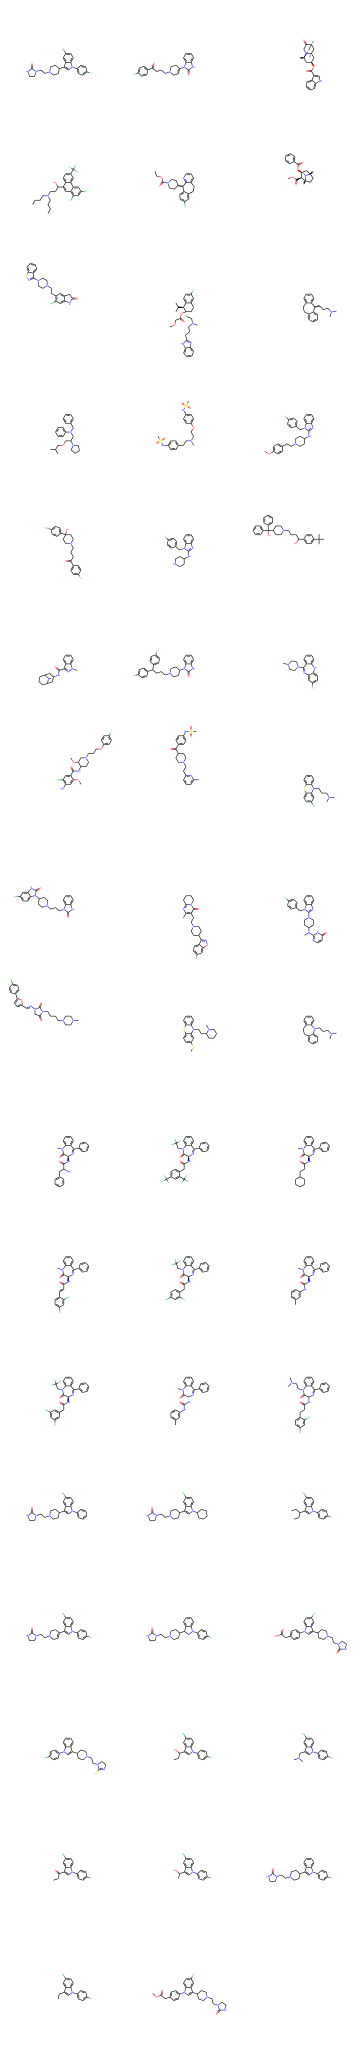

In [24]:
# Взглянем на молекулы, которые предсказались верно и были активными:
Z = molprop[(molprop["class_molprop"] == 1) & (molprop["class"] == 1)].index.values
Draw.MolsToGridImage([data[i] for i in Z], subImgSize=(400, 400), 
                     molsPerRow=3)

In [25]:
def print_smiles(df, Z, num_of_rows):
    # отображает smiles структур, в num_of_rows задаешь, сколько строчек надо отобразить
    smiles_right = df.loc[Z]
    res = smiles_right["canonical_smiles"].head(num_of_rows)
    return res
pd.set_option("max_colwidth", None)

In [26]:
res_right = print_smiles(df, Z, 10)
res_right

0                   O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc23)CC1
1                     O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F)cc1
2          O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c1c[nH]c2ccccc12
4                CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(F)F)ccc12
5                           CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1
6                 COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[C@H]1N2C
7                         O=C1Cc2cc(CCN3CCN(c4nsc5ccccc45)CC3)c(Cl)cc2N1
9     COCC(=O)O[C@]1(CCN(C)CCCc2nc3ccccc3[nH]2)CCc2cc(F)ccc2[C@@H]1C(C)C
12                                        CN(C)CCC=C1c2ccccc2CCc2ccccc21
14                               CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)N1CCCC1
Name: canonical_smiles, dtype: object

In [27]:
# 3272 молекулы предсказались как активные-блокаторы и на самом деле были неактивными-безопасными:
molprop[(molprop["class_molprop"]) & (molprop["class"] == 0)]

,molecule,QPlogHERG,IC50_nM,class_molprop,class
8,CHEMBL472,-5.401,3971.915495,1,0
10,CHEMBL192,-5.522,3006.076303,1,0
26,CHEMBL914,-6.678,209.893988,1,0
31,CHEMBL23,-6.375,421.696503,1,0
50,CHEMBL299590,-5.409,3899.419867,1,0
...,...,...,...,...,...
7867,CHEMBL4637181,-5.573,2673.006409,1,0
7868,CHEMBL4643511,-5.421,3793.149850,1,0
7869,CHEMBL4637358,-5.145,7161.434102,1,0
7871,CHEMBL4648883,-5.468,3404.081897,1,0


D:\Anaconda\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


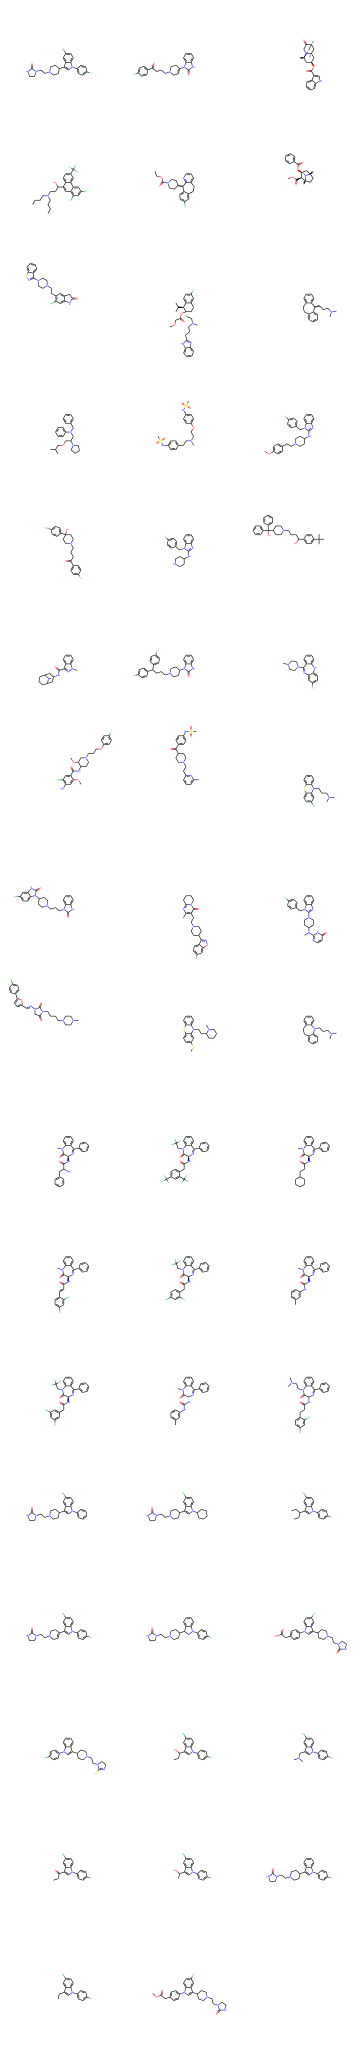

In [28]:
# Взглянем на молекулы, которые предсказались неверно:
Z1 = molprop[(molprop["class_molprop"]) & (molprop["class"] == 0)].index.values
Draw.MolsToGridImage([data[i] for i in Z], subImgSize=(400, 400), 
                     molsPerRow=3)

In [29]:
res_wrong = print_smiles(df, Z1, 10)
res_wrong

8           COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1
10    CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12
26    CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1
31         COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1
50                               CC(C)(C)c1ccc2c(ccn2-c2ccc(F)cc2)c1
54                         CCC(O)(CC)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12
56                             CC(=O)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12
57                                CCCc1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12
59                              CC(C)c1cn(-c2ccc(F)cc2)c2ccc(Cl)cc12
73                 COc1ccc(C(=O)N2CCN(c3ccc4c(c3)CCC(=O)N4)CC2)cc1OC
Name: canonical_smiles, dtype: object

Как видно, наличие третичного азота и двух ароматических колец не является показателем того, что молекула точно активна.
Какой-то закономерности у правильно предсказанных молекул vs неправильно предсказанных не наблюдается
Хорошо бы при создании модели использовать 3D-дескрипторы/фармакофорные дескрипторы. (поскольку может не так влиять наличие третичного атома азота и ароматических групп, как их расположение)

А также посомтрим на те молекулы, которые МолПроп отказался считать:

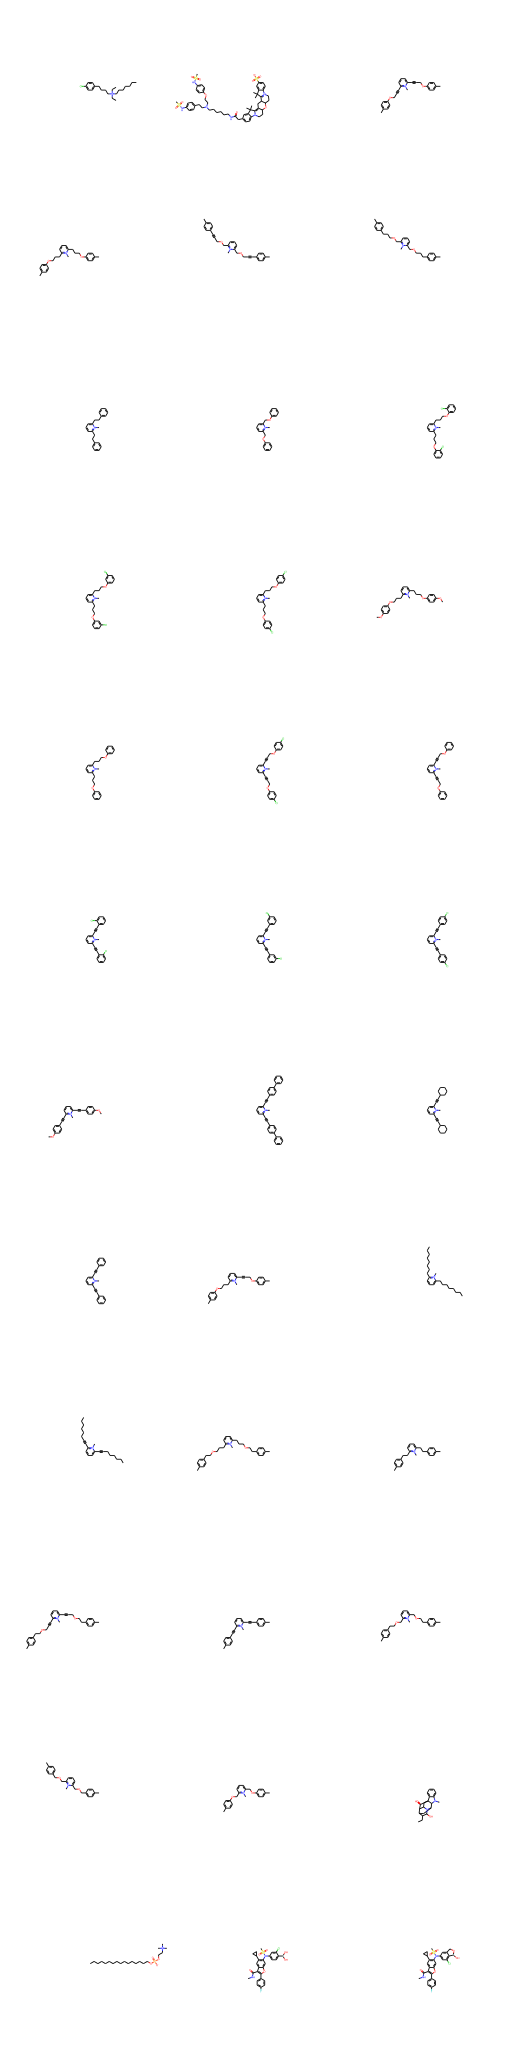

In [31]:
Draw.MolsToGridImage([data[i] for i in index_nan], subImgSize=(400, 400), 
                     molsPerRow=3)

In [32]:
res_wrong = print_smiles(df, index_nan, 10)
res_wrong

87                                                                                                            CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1
308     CC1(C)C2=C3CC4C5=[N+](CCC4OC3CCN2c2ccc(CC(=O)NCCCCCCN(CCOc3ccc(NS(C)(=O)=O)cc3)CCc3ccc(NS(C)(=O)=O)cc3)cc21)c1ccc(S(=O)(=O)[O-])cc1C5(C)C
3602                                                                                               Cc1ccc(OCC#Cc2cccc(C#CCOc3ccc(C)cc3)[n+]2C)cc1
3603                                                                                                 Cc1ccc(OCCCc2cccc(CCCOc3ccc(C)cc3)[n+]2C)cc1
3604                                                                                             Cc1ccc(C#CCOCc2cccc(COCC#Cc3ccc(C)cc3)[n+]2C)cc1
3605                                                                                               Cc1ccc(CCCOCc2cccc(COCCCc3ccc(C)cc3)[n+]2C)cc1
3607                                                                                                           C[n+]1c(CCc2c

У большинства этих молекул симметричное строение 

# Выводы.
- Приблизтельная оценка roc_auc на основе модели MolProp дает значение 0.57, что не соответствует требованиям (при roc_auc = 0.5 модель не видит отличия между классами совсем).
- Метрики recall и f1-score показали, что модели сложно определять класс nonblockers. 
- Какой-либо закономерности у правильно предсказанных молекул vs неправильно предсказанных визуально по формулам не обнаружено. 
- Стоит попробовать: методы классического машинного обучения. Построить корреляции между различными значениями дескрипторов и целевой активность IC50. 
- Суммируя с выводами из раздела сравнения выборок по similarity, использование фармакофорных моделей и далее фармакофорных дескрипторов (3D-QSAR) могло бы дать улучешие результатов.